In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.model_selection import train_test_split

## Description of problem and data

This project uses CNN to identify metastatic cancer in images. Each image is 96x96 pixels. There are 220,025 images in the training set and 57,458 images in the test set. The labels dataframe is 220,025 rows by 2 columns. The first column is 'id,' which is a unique alphanumeric code for each image. The second column is 'label,' which is a binary label indicating whether the 32x32 center pixels contain at least 1 pixel with cancer. 0 indicates noncancerous and 1 indicates cancerous.

In [3]:
# Directory paths
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'

# Labels
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# EDA
The dataset contains no null values. The distribution of positive and negative labels is not even, with 130,908 negative labels and 89,117 positive labels. The countplot displays the distribution of labels.

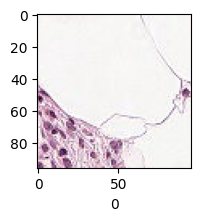

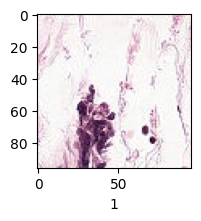

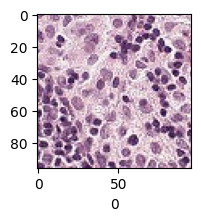

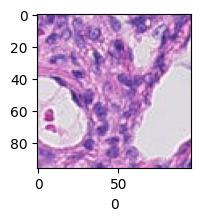

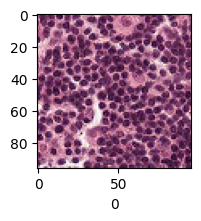

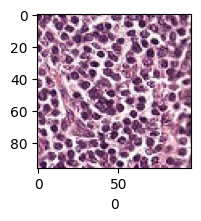

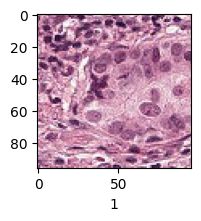

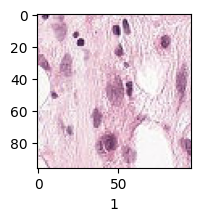

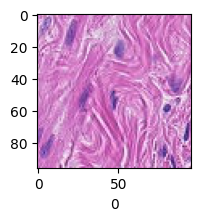

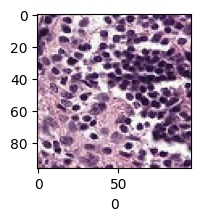

In [4]:
# Sample images
def show_img(x, y, idx):
    plt.figure(figsize = (15, 2))
    plt.imshow(Image.open(os.path.join(x, y['id'][idx] + '.tif')))
    plt.xlabel(y['label'][idx])

for i in range(10):
    show_img(train_dir, labels, i)
    plt.show()

In [5]:
print(labels.info())
print('Train:', len(os.listdir(train_dir)))
print('Test:', len(os.listdir(test_dir)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
Train: 220025
Test: 57458


In [6]:
# Check for missing values
print('Null Count')
print(labels.isnull().sum())

# Check for invalid values
print('Label Values')
print(labels['label'].value_counts())

# Check for duplicate ids
print('All ids are unique:')
print(labels['id'].nunique() == len(labels['id']))

Null Count
id       0
label    0
dtype: int64
Label Values
label
0    130908
1     89117
Name: count, dtype: int64
All ids are unique:
True


Text(0.5, 1.0, 'Training Labels')

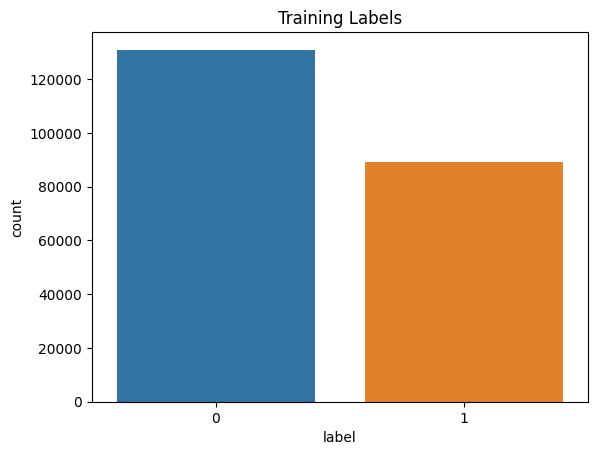

In [6]:
# Distribution of positive and negative labels within training dataset
sns.countplot(x = 'label', data = labels)
plt.title('Training Labels')

# Preprocessing
In order to process more quickly, I used a sample of the full dataset. My sample consisted of 10,000 rows. I also created a validation set in order to compare the training and validation within the notebook. To allow processing through flow_from_dataframe, I converted the labels to string datatype and added '.tif' to the id column so it provides the filename.

In [8]:
# Take random sample for faster processing time
sample = labels.sample(n = 10000, random_state = 42)

# Create validation set for evaluation
train_labels, val_labels = train_test_split(sample, test_size = 0.2, stratify = sample['label'], random_state = 42)
print(train_labels.shape)
print(val_labels.shape)

(8000, 2)
(2000, 2)


In [9]:
# Convert labels to strings for flow_from_dataframe
train_labels['label'] = train_labels['label'].astype(str)
val_labels['label'] = val_labels['label'].astype(str)

# Add .tif to id column so it provides filename
train_labels['id'] = train_labels['id'].astype(str) + '.tif'
val_labels['id'] = val_labels['id'].astype(str) + '.tif'

# Generate dataset
datagen = ImageDataGenerator(rescale = 1/255.0)

train = datagen.flow_from_dataframe(dataframe = train_labels,
                                    directory = train_dir,
                                    x_col = 'id',
                                    y_col = 'label',
                                    target_size = (96, 96),
                                    class_mode = 'binary')
val = datagen.flow_from_dataframe(dataframe = val_labels,
                                 directory = train_dir,
                                 x_col = 'id',
                                 y_col = 'label',
                                 target_size = (96, 96),
                                 class_mode = 'binary')

Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


# Model design
I created 3 models to compare to experiment with different numbers of layers and the use of dropout layers.
- The first model is the simplest and uses two pairs of convolution and max-pooling layers.
- The second model adds two additional convolution and max-pooling layers for a total of four.
- The third model adds dropout layers.\
Additional convolution layers allow for identification of more complex features, so the deeper models may be more accurate. Dropout layers help prevent overfitting, so comparing models with and without dropout layers helps identify whether overfitting has occurred.

In [10]:
# Simple model with 2 convolution and max-pooling layers
simple_mod = Sequential([
        Input((96, 96, 3)),
        Conv2D(32, (3, 3), activation = 'relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation = 'relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ])
    

simple_mod.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Adding 2 convolution layers
deeper_mod = Sequential([Input((96, 96, 3)),
                         Conv2D(32, (3, 3), activation = 'relu'),
                         MaxPooling2D(2, 2),
                         Conv2D(64, (3, 3), activation = 'relu'),
                         MaxPooling2D(2, 2),
                         Conv2D(64, (3, 3), activation = 'relu'),
                         MaxPooling2D(2, 2),
                         Conv2D(64, (3, 3), activation = 'relu'),
                         MaxPooling2D(2, 2),
                         Flatten(),
                         Dense(128, activation = 'relu'),
                         Dense(1, activation = 'sigmoid')])
    

deeper_mod.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,577 (877.25 KB)

 Trainable params: 224,577 (877.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Add dropout layers
dropout_mod = Sequential([Input((96, 96, 3)),
                         Conv2D(32, (3, 3), activation = 'relu'),
                         MaxPooling2D(2, 2),
                         Conv2D(64, (3, 3), activation = 'relu'),
                         MaxPooling2D(2, 2),
                         Conv2D(64, (3, 3), activation = 'relu'),
                         MaxPooling2D(2, 2),
                         Conv2D(64, (3, 3), activation = 'relu'),
                         MaxPooling2D(2, 2),
                         Dropout(0.5),
                         Flatten(),
                         Dense(128, activation = 'relu'),
                         Dropout(0.5),
                         Dense(1, activation = 'sigmoid')])
    

dropout_mod.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,577 (877.25 KB)

 Trainable params: 224,577 (877.25 KB)

 Non-trainable params: 0 (0.00 B)

# Training
Each model used an adam optimizer and binary crossentropy loss function.

In [12]:
# Compile and train simple model
simple_mod.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

simple_history = simple_mod.fit(train, epochs = 10, validation_data = val)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 267ms/step - accuracy: 0.6214 - loss: 0.8241 - val_accuracy: 0.7755 - val_loss: 0.5195
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 278ms/step - accuracy: 0.7685 - loss: 0.4963 - val_accuracy: 0.7930 - val_loss: 0.4531
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 268ms/step - accuracy: 0.8076 - loss: 0.4328 - val_accuracy: 0.7730 - val_loss: 0.4860
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 276ms/step - accuracy: 0.8170 - loss: 0.4078 - val_accuracy: 0.7855 - val_loss: 0.4763
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 266ms/step - accuracy: 0.8723 - loss: 0.3071 - val_accuracy: 0.7815 - val_loss: 0.5090
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 268ms/step - accuracy: 0.9256 - loss: 0.2061 - val_accuracy: 0.7630 - val_loss: 0.6908
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 269ms/step - accuracy: 0.9413 - loss: 0.1576 - val_accuracy: 0.7715 - val_loss: 0.7064
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 269ms/step - accuracy: 0.9643 - loss: 0.1069 - val

In [13]:
# Compile and train deeper model
deeper_mod.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

deeper_history = deeper_mod.fit(train, epochs = 10, validation_data = val)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 295ms/step - accuracy: 0.6245 - loss: 0.6292 - val_accuracy: 0.7935 - val_loss: 0.4650
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 287ms/step - accuracy: 0.7800 - loss: 0.4843 - val_accuracy: 0.7890 - val_loss: 0.5026
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 293ms/step - accuracy: 0.7887 - loss: 0.4633 - val_accuracy: 0.7930 - val_loss: 0.4600
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 73s 292ms/step - accuracy: 0.8029 - loss: 0.4362 - val_accuracy: 0.8075 - val_loss: 0.4289
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 287ms/step - accuracy: 0.8079 - loss: 0.4294 - val_accuracy: 0.8065 - val_loss: 0.4364
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 288ms/step - accuracy: 0.8167 - loss: 0.4237 - val_accuracy: 0.8100 - val_loss: 0.4113
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 73s 290ms/step - accuracy: 0.8240 - loss: 0.4015 - val_accuracy: 0.8090 - val_loss: 0.4105
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 286ms/step - accuracy: 0.8268 - loss: 0

In [14]:
# Compile and train dropout model
dropout_mod.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

dropout_history = dropout_mod.fit(train, epochs = 10, validation_data = val)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 293ms/step - accuracy: 0.6517 - loss: 0.6183 - val_accuracy: 0.7980 - val_loss: 0.4708
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 294ms/step - accuracy: 0.7841 - loss: 0.4736 - val_accuracy: 0.7990 - val_loss: 0.4421
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 291ms/step - accuracy: 0.7845 - loss: 0.4771 - val_accuracy: 0.7945 - val_loss: 0.4530
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 75s 296ms/step - accuracy: 0.8020 - loss: 0.4498 - val_accuracy: 0.7765 - val_loss: 0.4585
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 295ms/step - accuracy: 0.8081 - loss: 0.4481 - val_accuracy: 0.8065 - val_loss: 0.4333
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 297ms/step - accuracy: 0.8152 - loss: 0.4233 - val_accuracy: 0.8070 - val_loss: 0.4273
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 73s 291ms/step - accuracy: 0.8194 - loss: 0.4186 - val_accuracy: 0.8365 - val_loss: 0.3888
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 73s 290ms/step - accuracy: 0.8216 - loss: 0

## Compare Adam to RMSprop
The two deeper models performed better than the model with only two convolution layers. For that reason, I will compared optimizers for those two models. For the model without dropout layers, both Adam and RMSprop achieved similar results. For the model with dropout layer, RMSprop performed worse than Adam. I decided to move forward with Adam as the optimizer for both models.

In [13]:
# Compile and train deeper model with RMSprop
deeper_mod.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

deeper_history2 = deeper_mod.fit(train, epochs = 10, validation_data = val)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 98s 377ms/step - accuracy: 0.6317 - loss: 0.6438 - val_accuracy: 0.7135 - val_loss: 0.5815
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 62s 246ms/step - accuracy: 0.7742 - loss: 0.5026 - val_accuracy: 0.7555 - val_loss: 0.5209
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 244ms/step - accuracy: 0.7785 - loss: 0.4830 - val_accuracy: 0.8155 - val_loss: 0.4299
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 62s 245ms/step - accuracy: 0.7994 - loss: 0.4577 - val_accuracy: 0.8040 - val_loss: 0.4360
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 245ms/step - accuracy: 0.7987 - loss: 0.4466 - val_accuracy: 0.8035 - val_loss: 0.4435
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 244ms/step - accuracy: 0.8039 - loss: 0.4331 - val_accuracy: 0.8140 - val_loss: 0.4106
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 241ms/step - accuracy: 0.8168 - loss: 0.4232 - val_accuracy: 0.8325 - val_loss: 0.3886
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 241ms/step - accuracy: 0.8273 - loss: 0.3957 - val

In [14]:
# Compile and train dropout model with RMSprop
dropout_mod.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

dropout_history2 = dropout_mod.fit(train, epochs = 10, validation_data = val)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 248ms/step - accuracy: 0.6145 - loss: 0.6536 - val_accuracy: 0.8020 - val_loss: 0.4687
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 244ms/step - accuracy: 0.7682 - loss: 0.5088 - val_accuracy: 0.7820 - val_loss: 0.4797
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 243ms/step - accuracy: 0.7648 - loss: 0.5027 - val_accuracy: 0.8010 - val_loss: 0.4437
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 245ms/step - accuracy: 0.7821 - loss: 0.4787 - val_accuracy: 0.7810 - val_loss: 0.4556
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 62s 245ms/step - accuracy: 0.7972 - loss: 0.4538 - val_accuracy: 0.7740 - val_loss: 0.4996
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 62s 246ms/step - accuracy: 0.7889 - loss: 0.4553 - val_accuracy: 0.8240 - val_loss: 0.3984
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 62s 245ms/step - accuracy: 0.8073 - loss: 0.4375 - val_accuracy: 0.8135 - val_loss: 0.4120
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 242ms/step - accuracy: 0.8122 - loss: 0

# Evaluation

In [15]:
# Plot accuracy and loss functions
def acc_plot(history):
    plt.figure(figsize = (10, 5))
    plt.plot(history.history['accuracy'], label = 'Training Accuracy')
    plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')
    plt.xlabel('Epoch', fontsize = 16)
    plt.ylabel('Accuracy', fontsize = 16)
    plt.ylim([0, 1])
    plt.title('Training and Test Accuracy', fontsize = 16)
    plt.show()

def loss_plot(history):
    plt.figure(figsize = (10, 5))
    plt.plot(history.history['loss'], label = 'Training Loss')
    plt.plot(history.history['val_loss'], label = 'Validation Loss')
    plt.title('Training and Test Loss', fontsize = 16)
    plt.legend(loc = 'lower right')
    plt.xlabel('Epoch', fontsize = 16)
    plt.ylabel('Loss', fontsize = 16)
    plt.show()

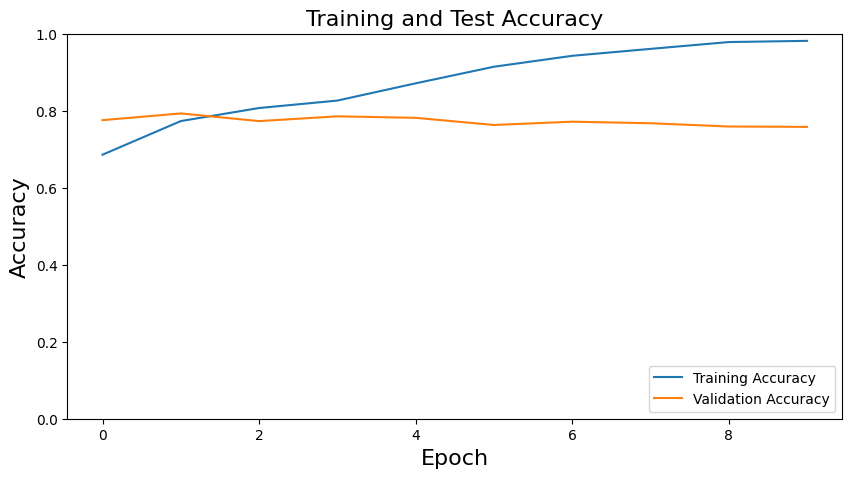

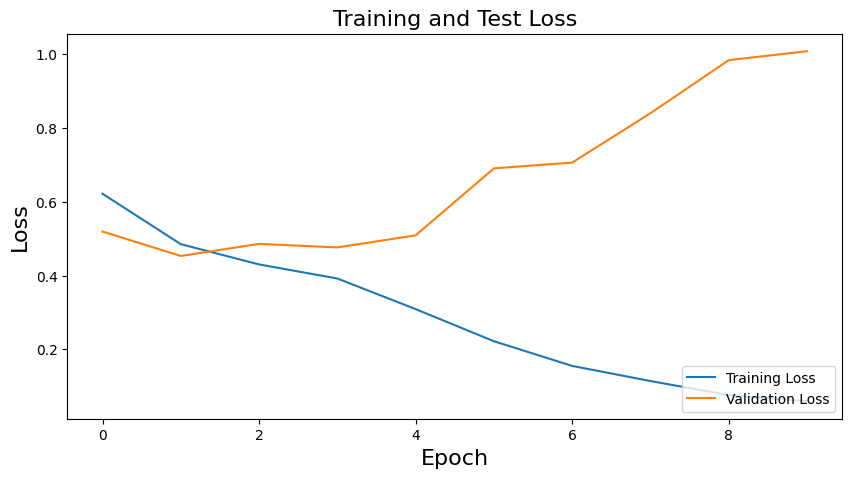

In [16]:
# Plots for simple model
acc_plot(simple_history)
loss_plot(simple_history)

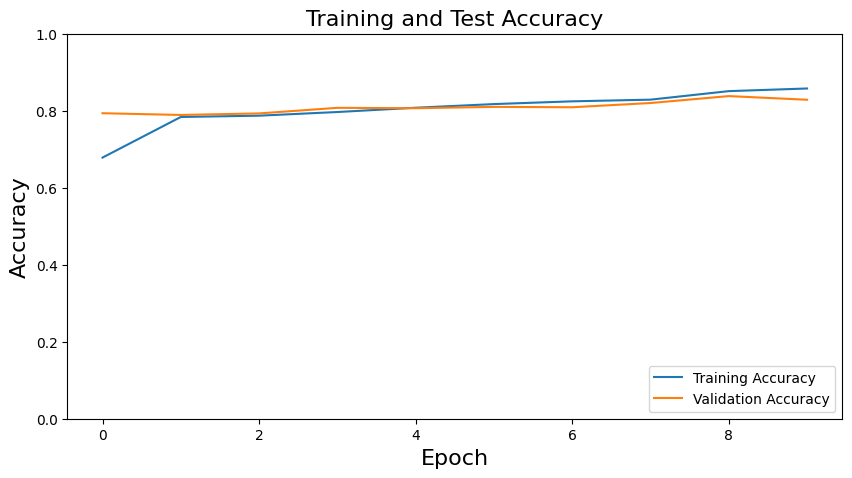

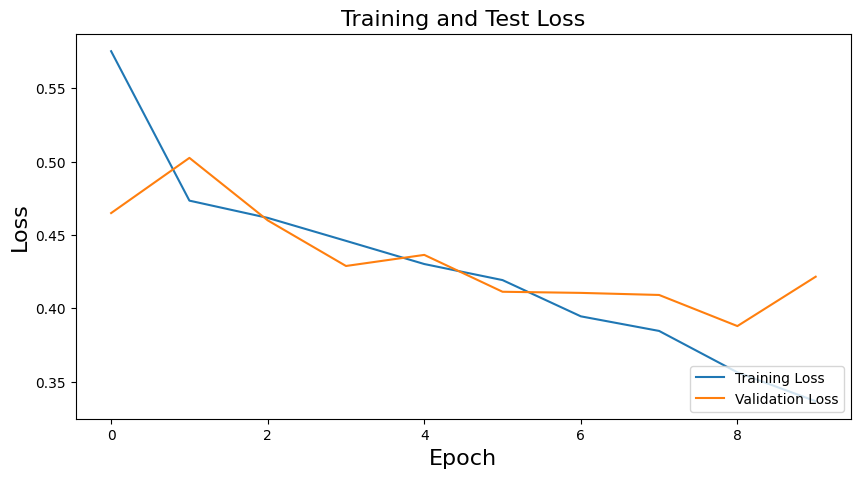

In [17]:
# Plots for deeper model
acc_plot(deeper_history)
loss_plot(deeper_history)

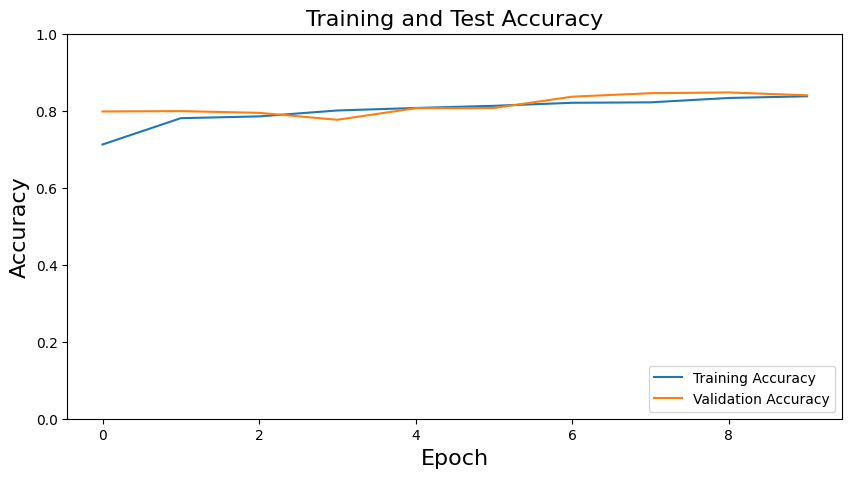

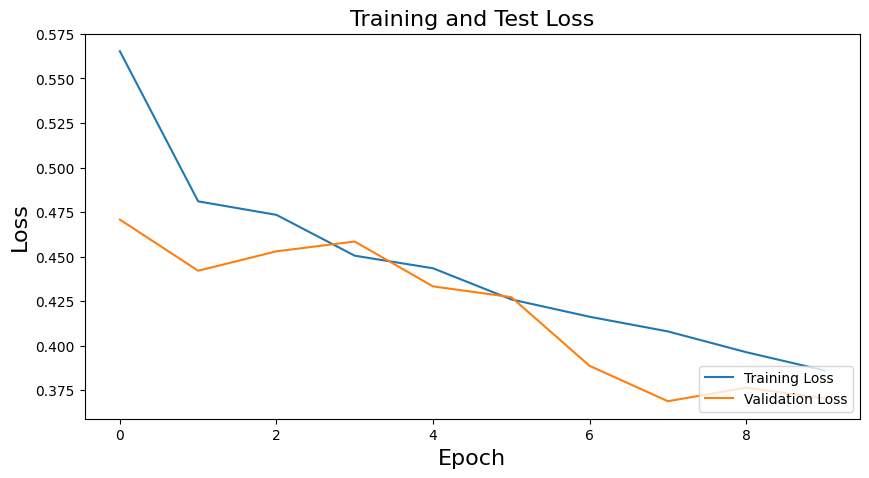

In [18]:
# Plots for dropout model
acc_plot(dropout_history)
loss_plot(dropout_history)

# Conclusion
Using the Adam optimizer, the model with dropout layers perfomed best. The training and validation accuracies were very similar and the validation loss was lower than the training loss. The first model, which had only two convolution layers and no dropout showed overfitting because the training accuracy was much higher than the validation accuracy. The second model had similar accuracy between training and validation, but the validation loss began to increase in later epochs. It is expected that a deeper model would perform better because the images require analysis of more detailed features in order to differentiate between images of cancer and noncancer.

# References
- https://www.geeksforgeeks.org/how-to-decide-number-of-filters-in-cnn/
- https://medium.com/@esrasoylu/creating-a-cnn-model-for-image-classification-with-tensorflow-49b84be8c12a
- https://medium.com/@sssspppp/image-classification-using-cnn-0fad8367acfd
- https://www.geeksforgeeks.org/convolutional-neural-network-cnn-in-machine-learning/
- https://www.kaggle.com/code/grainier/histopathologic-cancer-detection-using-cnn